In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import json

from tqdm import tqdm

In [ ]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fc5385727f0>)

- 데이터 불러오기 및 분석하기

In [ ]:
DATA_IN_PATH = './'
print("파일 크기 : ")
for file in os.listdir(DATA_IN_PATH):
    if 'txt' in file :
        print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + file) / 1000000, 2)) + 'MB')

파일 크기 : 
ratings_train.txt             14.63MB
ratings.txt                   19.52MB
ratings_test.txt              4.89MB


In [ ]:
train_data = pd.read_csv(DATA_IN_PATH + 'ratings_train.txt', header = 0, delimiter = '\t', quoting = 3)
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
print('전체 학습데이터의 개수: {}'.format(len(train_data)))

전체 학습데이터의 개수: 150000


In [ ]:
train_length = train_data['document'].astype(str).apply(len)

In [ ]:
train_length.head()

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

Text(0, 0.5, 'Number of review')

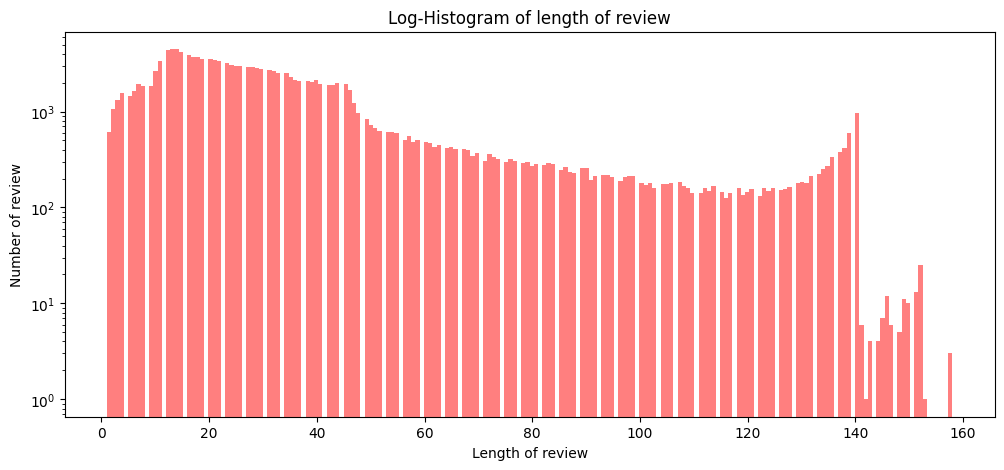

In [ ]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_length, bins=200, alpha=0.5, color= 'r', label='word')
plt.yscale('log')
# 그래프 제목
plt.title('Log-Histogram of length of review')
# 그래프 x 축 라벨
plt.xlabel('Length of review')
# 그래프 y 축 라벨
plt.ylabel('Number of review')

In [ ]:
print('리뷰 길이 최대 값: {}'.format(np.max(train_length)))
print('리뷰 길이 최소 값: {}'.format(np.min(train_length)))
print('리뷰 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('리뷰 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('리뷰 길이 중간 값: {}'.format(np.median(train_length)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('리뷰 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('리뷰 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

리뷰 길이 최대 값: 158
리뷰 길이 최소 값: 1
리뷰 길이 평균 값: 35.24
리뷰 길이 표준편차: 29.58
리뷰 길이 중간 값: 27.0
리뷰 길이 제 1 사분위: 16.0
리뷰 길이 제 3 사분위: 42.0


- 할거 더 하시고

### 데이터 전처리

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
# 모듈 불러오기
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
DATA_IN_PATH ='./'
train_data = pd.read_csv(DATA_IN_PATH + 'ratings_train.txt', header=0, delimiter='\t', quoting=3 )
print(train_data.head())

         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


In [ ]:
review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", train_data['document'][0]) 
print(review_text)

아 더빙 진짜 짜증나네요 목소리


In [ ]:
okt=Okt()
review_text = okt.morphs(review_text, stem=True)
print(review_text)

['아', '더빙', '진짜', '짜증나다', '목소리']


In [ ]:
stop_words = set(['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한'])
clean_review = [token for token in review_text if not token in stop_words]
print(clean_review)

['더빙', '진짜', '짜증나다', '목소리']


In [ ]:
def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    # 함수의 인자는 다음과 같다.
    # review : 전처리할 텍스트
    # okt : okt 객체를 반복적으로 생성하지 않고 미리 생성후 인자로 받는다.
    # remove_stopword : 불용어를 제거할지 선택 기본값은 False
    # stop_word : 불용어 사전은 사용자가 직접 입력해야함 기본값은 비어있는 리스트
    
    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", review)
    
    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.morphs(review_text, stem=True)
    
    if remove_stopwords:
        
        # 불용어 제거(선택적)
        word_review = [token for token in word_review if not token in stop_words]
        
   
    return word_review

In [ ]:
stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
okt = Okt()
clean_train_review = []

for review in tqdm(train_data['document']):   ## 코드 실행 시간이 긴 관계로 tqdm을 추가함
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_review.append([])  #string이 아니면 비어있는 값 추가

100%|██████████| 150000/150000 [10:31<00:00, 237.50it/s]


In [ ]:
test_data = pd.read_csv(DATA_IN_PATH + 'ratings_test.txt', header=0, delimiter='\t', quoting=3 )

clean_test_review = []

for review in test_data['document']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_test_review.append([])  #string이 아니면 비어있는 값 추가

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index # 단어 사전 형태
word_vocab["<PAD>"] = 0

In [ ]:
MAX_SEQUENCE_LENGTH = 8 # 문장 최대 길이

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 학습 데이터를 벡터화
train_labels = np.array(train_data['label']) # 학습 데이터의 라벨

test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 테스트 데이터를 벡터화
test_labels = np.array(test_data['label']) # 테스트 데이터의 라벨

In [ ]:
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'data_configs.json'

data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) # vocab size 추가

import os
# 저장하는 디렉토리가 존재하지 않으면 생성
if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)

# 전처리 된 학습 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)
# 전처리 된 테스트 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_LABEL_DATA, 'wb'), test_labels)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)